##Importing##

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
import os
import keras
from keras import layers

In [2]:
os.listdir("./")

['ai4pain_cnn.ipynb', 'Test', 'Train', 'Validation']

In [3]:
path_train =  os.path.join("./", 'Train')
path_test = os.path.join("./","Test")
path_val = os.path.join("./","Validation")

In [4]:
path_val

'./Validation'

## Carregando diretório #

In [5]:
BATCH_SIZE = 4
IMG_SIZE = (224,224) # Tamanho da imagem de entrada para a rede pre treinada
NUM_FRAMES = 16
AUTO = tf.data.AUTOTUNE
SEED = 42

In [6]:
# Função para carregar o vídeo
def load_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < NUM_FRAMES:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, IMG_SIZE)
        frames.append(frame)
    cap.release()
    # Preenche com frames em branco se o vídeo tiver menos que NUM_FRAMES
    while len(frames) < NUM_FRAMES:
        frames.append(np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32))
    frames = np.array(frames, dtype=np.float32)
    frames = frames / 255.0  # Normalização
    return frames

In [7]:
# Função para determinar a classe a partir do nome do arquivo
def get_label_from_filename(filename):
    #print(filename)
    if "_Pain_HIGH_" in filename:
        return 0  # High Pain
    elif "_Pain_LOW_" in filename:
        return 1  # Low Pain
    elif "_Rest_" in filename:
        return 2  # Rest
    elif "_Baseline" in filename:
        #ignorar
        return -1
    else:
        print("Erro no arquivo:",filename)
        raise ValueError("Nome de arquivo '"+filename+"' inválido para classificação")

In [ ]:
# def video_dataset(data_dir):
#     videos = []
#     labels = []
#     for class_dir in sorted(os.listdir(data_dir)):
#         print(f"Class directory: {class_dir}")  # Add this line for debugging
#         if class_dir == 'fnirs':  # Ignora a pasta 'fnirs'
#             continue
#         full_class_dir = os.path.join(data_dir, class_dir)
#         print(f"Full class directory: {full_class_dir}")  # Add this line for debugging
#         if os.path.isdir(full_class_dir):
#             # Iterate through subdirectories within the class directory
#             for subdir in os.listdir(full_class_dir):
#                 subdir_path = os.path.join(full_class_dir, subdir)
#                 if os.path.isdir(subdir_path):
#                     # Iterate through video files within the subdirectory
#                     for video_file in os.listdir(subdir_path):
#                         if video_file.endswith('.mp4'):
#                             video_path = os.path.join(subdir_path, video_file)
#                             videos.append(load_video(video_path))
#                             labels.append(get_label_from_filename(video_file))

#     print("FINISHED")
#     print(f"Number of videos loaded: {len(videos)}")  # Add this line for debugging
#     videos = tf.ragged.constant(videos)
#     labels = tf.constant(labels)
#     dataset = tf.data.Dataset.from_tensor_slices((videos, labels))
#     if videos.shape[0] > 0:
#         dataset = dataset.shuffle(buffer_size=videos.shape[0], seed=SEED)
#     else:
#         print("Warning: No videos loaded. Skipping shuffle.")  # Add this line for debugging
#     dataset = dataset.batch(BATCH_SIZE).prefetch(AUTO)
#     return dataset

In [8]:
def load_videos_in_batches(data_dir, batch_size):
    videos = []
    labels = []
    current_batch = 0
    
    for class_dir in sorted(os.listdir(data_dir)):
        if class_dir == 'fnirs':  # Ignora a pasta 'fnirs'
            continue
        full_class_dir = os.path.join(data_dir, class_dir)
        if os.path.isdir(full_class_dir):
            for subdir in os.listdir(full_class_dir):
                subdir_path = os.path.join(full_class_dir, subdir)
                if os.path.isdir(subdir_path):
                    for video_file in os.listdir(subdir_path):
                        if video_file.endswith('.mp4'):
                            video_path = os.path.join(subdir_path, video_file)
                            video_data = load_video(video_path)
                            label = get_label_from_filename(video_file)
                            if label != -1:  # Ignora vídeos com label -1
                                videos.append(video_data)
                                labels.append(label)
                                
                                # Processa um batch de tamanho batch_size
                                if len(videos) == batch_size:
                                    yield np.array(videos, dtype=np.float32), np.array(labels, dtype=np.int32)
                                    videos, labels = [], []  # Limpa as listas para o próximo batch
                                    current_batch += 1
                                    print(f"Processed batch {current_batch}")
    
    # Resto dos vídeos no último batch (se houver)
    if videos:
        yield np.array(videos, dtype=np.float32), np.array(labels, dtype=np.int32)
        print(f"Processed final batch {current_batch + 1}")


In [13]:
dataset = tf.data.Dataset.from_generator(
    lambda: load_videos_in_batches(path_train, BATCH_SIZE),
    output_signature=(
        tf.TensorSpec(shape=(None, NUM_FRAMES, *IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).prefetch(AUTO)

In [14]:
validation = tf.data.Dataset.from_generator(
    lambda: load_videos_in_batches(path_val, BATCH_SIZE),
    output_signature=(
        tf.TensorSpec(shape=(None, NUM_FRAMES, *IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).prefetch(AUTO)


In [15]:
# Teste para ver como os batches estão sendo carregados
for i, (videos_batch, labels_batch) in enumerate(dataset.take(5)):  # Limite para 5 batches de teste
    print(f"Batch {i+1}:")
    print(f"  Videos shape: {videos_batch.shape}")
    print(f"  Labels shape: {labels_batch.shape}")

Batch 1:
  Videos shape: (4, 16, 224, 224, 3)
  Labels shape: (4,)
Processed batch 1
Processed batch 2
Batch 2:
  Videos shape: (4, 16, 224, 224, 3)
  Labels shape: (4,)
Processed batch 3
Batch 3:
  Videos shape: (4, 16, 224, 224, 3)
  Labels shape: (4,)
Processed batch 4Batch 4:
  Videos shape: (4, 16, 224, 224, 3)
  Labels shape: (4,)

Batch 5:
  Videos shape: (4, 16, 224, 224, 3)
  Labels shape: (4,)
Processed batch 5


# Verificar divisão do dataset

In [16]:
class_counts = {"high pain": 0, "low pain": 0, "rest": 0}
for _, labels_batch in dataset:
    for label in labels_batch.numpy():
        if label == 0:
            class_counts["high pain"] += 1
        elif label == 1:
            class_counts["low pain"] += 1
        elif label == 2:
            class_counts["rest"] += 1
print("Class distribution:", class_counts)


Processed batch 1
Processed batch 2
Processed batch 3
Processed batch 4
Processed batch 5
Processed batch 6
Processed batch 7
Processed batch 8
Processed batch 9
Processed batch 10
Processed batch 11
Processed batch 12
Processed batch 13
Processed batch 14
Processed batch 15
Processed batch 16
Processed batch 17
Processed batch 18
Processed batch 19
Processed batch 20
Processed batch 21
Processed batch 22
Processed batch 23
Processed batch 24
Processed batch 25
Processed batch 26
Processed batch 27
Processed batch 28
Processed batch 29
Processed batch 30
Processed batch 31
Processed batch 32
Processed batch 33
Processed batch 34
Processed batch 35
Processed batch 36
Processed batch 37
Processed batch 38
Processed batch 39
Processed batch 40
Processed batch 41
Processed batch 42
Processed batch 43
Processed batch 44
Processed batch 45
Processed batch 46
Processed batch 47
Processed batch 48
Processed batch 49
Processed batch 50
Processed batch 51
Processed batch 52
Processed final batch

### Criando modelo

In [31]:
# Definição do modelo
def create_model():
    model = models.Sequential([
        layers.Conv3D(32, (3, 3, 3), activation='relu', input_shape=(NUM_FRAMES, *IMG_SIZE, 3)),
        layers.MaxPooling3D((2, 2, 2)),
        layers.Conv3D(64, (3, 3, 3), activation='relu'),
        layers.MaxPooling3D((2, 2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(3, activation='softmax')  # 3 classes: high pain, low pain, rest
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 14, 222, 222, 32)  2624      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 7, 111, 111, 32)  0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 5, 109, 109, 64)   55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 2, 54, 54, 64)    0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 373248)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [32]:
EPOCHS = 30

history = model.fit(
    dataset,
    validation_data=validation,
    epochs=EPOCHS
)


Epoch 1/30
Processed batch 1
      1/Unknown - 1s 827ms/step - loss: 1.1202 - accuracy: 0.0000e+00Processed batch 2
      2/Unknown - 1s 157ms/step - loss: 17.8295 - accuracy: 0.1250   Processed batch 3
      3/Unknown - 1s 158ms/step - loss: 23.3175 - accuracy: 0.0833Processed batch 4
      4/Unknown - 1s 159ms/step - loss: 19.8882 - accuracy: 0.1250Processed batch 5
Processed batch 6
      5/Unknown - 1s 163ms/step - loss: 16.0632 - accuracy: 0.2500Processed batch 7
      6/Unknown - 2s 163ms/step - loss: 13.6481 - accuracy: 0.2500Processed batch 8
      7/Unknown - 2s 164ms/step - loss: 11.8564 - accuracy: 0.2500Processed batch 9
      8/Unknown - 2s 163ms/step - loss: 10.5078 - accuracy: 0.3438Processed batch 10
      9/Unknown - 2s 163ms/step - loss: 9.4625 - accuracy: 0.3333 Processed batch 11
     10/Unknown - 2s 161ms/step - loss: 8.6250 - accuracy: 0.3000Processed batch 12
     11/Unknown - 2s 162ms/step - loss: 7.9360 - accuracy: 0.3636Processed batch 13
     12/Unknown - 3s 

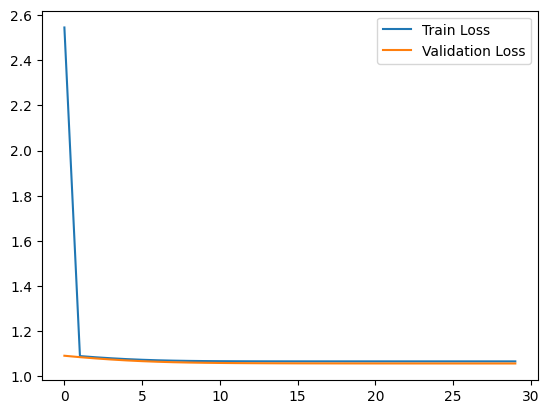

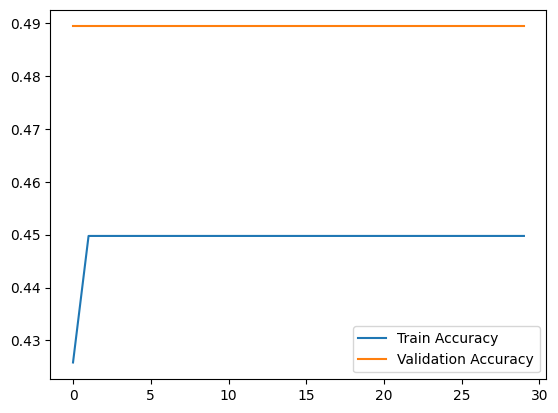

In [33]:
import matplotlib.pyplot as plt

# Perda
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Acurácia
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
